# XGBoost Starter - LB 0.793
In this notebook we build and train an XGBoost model using @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we engineer features suggested by @huseyincot in his notebooks [here][3] and [here][4]. This XGB model achieves CV 0.792 LB 0.793! When training with XGB, we use a special XGB dataloader called `DeviceQuantileDMatrix` which uses a small GPU memory footprint. This allows us to engineer more additional columns and train with more rows of data. Our feature engineering is performed using [RAPIDS][5] on the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

# Load Libraries

In [1]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os

print('RAPIDS version',cudf.__version__)

RAPIDS version 21.10.01


In [2]:
'''
# cannot load data
train_amex_default = pd.read_csv('../input/amex-default-prediction/train_data.csv')
print(train_amex_default.shape)
del train_amex_default
'''

"\n# cannot load data\ntrain_amex_default = pd.read_csv('../input/amex-default-prediction/train_data.csv')\nprint(train_amex_default.shape)\ndel train_amex_default\n"

In [3]:
'''
train_amex_feather = pd.read_feather('../input/amexfeather/train_data.ftr')
print(train_amex_feather.shape)
del train_amex_feather
'''

"\ntrain_amex_feather = pd.read_feather('../input/amexfeather/train_data.ftr')\nprint(train_amex_feather.shape)\ndel train_amex_feather\n"

In [4]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1

# TRAIN RANDOM SEED
SEED = 21

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 2

# Process and Feature Engineer Train Data
We will load @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we will engineer features suggested by @huseyincot in his notebooks [here][3] and [here][4]. We will use [RAPIDS][5] and the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

In [5]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = cudf.read_parquet(path, columns=usecols)
    else: df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df.S_2 = cudf.to_datetime( df.S_2 )
    # SORT BY CUSTOMER AND DATE (so agg('last') works correctly)
    #df = df.sort_values(['customer_ID','S_2'])
    #df = df.reset_index(drop=True)
    # FILL NAN
    df = df.fillna(NAN_VALUE) 
    print('shape of data:', df.shape)
    
    return df

print('Reading train data...')
TRAIN_PATH = '../input/amex-data-integer-dtypes-parquet-format/train.parquet'
train = read_file(path = TRAIN_PATH)

Reading train data...
shape of data: (5531451, 190)


In [6]:
# truncate
train = train.iloc[:int(train.shape[0]/100),:]
print('shape of truncated data:', train.shape)

shape of truncated data: (55314, 190)


In [7]:
# train.head()

In [8]:
def process_and_feature_engineer(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

# train = process_and_feature_engineer(train)

In [9]:
def process_and_feature_engineer_last_stmt(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    test_num_agg = df.groupby("customer_ID")[num_features].agg('last')
    #test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg('last')
    #test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

train = process_and_feature_engineer_last_stmt(train)

shape after engineering (4595, 188)


Data prep code from Joe Burns

In [10]:
# Preparing the TRAINING data for creating the model.
def prep_df(df):
    # Set index
    # df = df.iloc[:,~df.columns.duplicated()]

    # Drop unecessary columns
    df = df.drop(columns=["customer_ID", "S_2"])

    # Missing values handling
    missing_props = df.isna().mean(axis=0)
    

    over_threshold = missing_props[missing_props >= 0.4]
    # print(f'over_threshold = {over_threshold}')
    over_threshold = over_threshold.to_pandas()

    df.drop(over_threshold.index, 
            axis=1, 
            inplace=True)

    
    
    return df

# train = prep_df(train)

In [11]:
train.shape

(4595, 188)

In [12]:
# ADD TARGETS
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()

# FEATURES
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 188 features!


# Train XGB
We will train using `DeviceQuantileDMatrix`. This has a very small GPU memory footprint.

In [13]:
# LOAD XGB LIBRARY
from sklearn.model_selection import KFold
import xgboost as xgb
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.1, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.6.1


In [14]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [15]:
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [16]:
importances = []
oof = []
train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

del oof

#########################
### Fold 1
### Train size 2297 Valid size 2298
### Training with 100% fold data...
#########################
[0]	train-logloss:0.63302	valid-logloss:0.63671
[100]	train-logloss:0.07719	valid-logloss:0.27829
[147]	train-logloss:0.05034	valid-logloss:0.28745
Kaggle Metric = 0.7096252198246621 

#########################
### Fold 2
### Train size 2298 Valid size 2297
### Training with 100% fold data...
#########################
[0]	train-logloss:0.63400	valid-logloss:0.63716
[100]	train-logloss:0.09919	valid-logloss:0.24799
[175]	train-logloss:0.05002	valid-logloss:0.25577
Kaggle Metric = 0.7591148047643254 

#########################
OVERALL CV Kaggle Metric = 0.7351658391858302


In [17]:

# CLEAN RAM
del train
_ = gc.collect()


# Save OOF Preds

In [18]:
'''
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()
'''

"\noof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()\noof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')\noof_xgb = oof_xgb.set_index('customer_ID_hash')\noof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)\noof_xgb = oof_xgb.sort_index().reset_index(drop=True)\noof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)\noof_xgb.head()\n"

In [19]:
'''
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()
'''

"\n# PLOT OOF PREDICTIONS\nplt.hist(oof_xgb.oof_pred.values, bins=100)\nplt.title('OOF Predictions')\nplt.show()\n"

In [20]:
'''
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof
_ = gc.collect()
'''

'\n# CLEAR VRAM, RAM FOR INFERENCE BELOW\ndel oof_xgb, oof\n_ = gc.collect()\n'

# Feature Importance

In [21]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

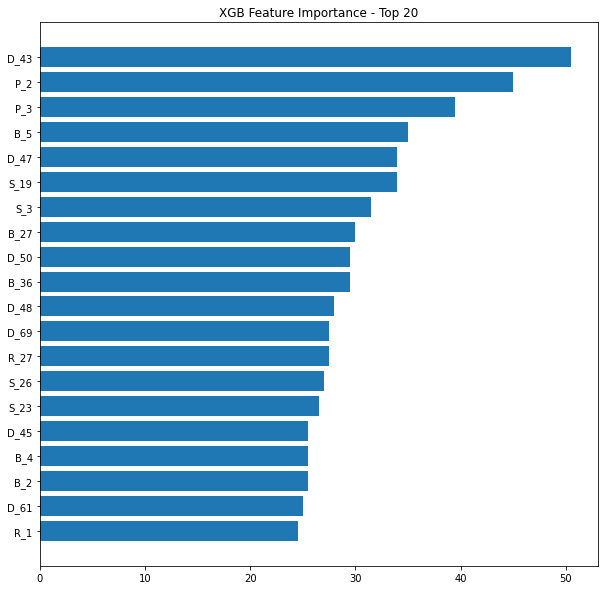

In [22]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Process and Feature Engineer Test Data
We will load @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we will engineer features suggested by @huseyincot in his notebooks [here][1] and [here][4]. We will use [RAPIDS][5] and the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

In [23]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 40
TEST_PATH = '../input/amex-data-integer-dtypes-parquet-format/test.parquet'

print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')
# print(f'rows shape = {rows.shape}, chunk shape = {len(num_cust)}')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 40 separate parts.
There will be 23115 customers in each part (except the last part).
Below are number of rows in each part:
[284115, 283805, 284292, 284177, 284473, 284887, 284268, 283601, 283871, 283663, 284162, 283860, 284154, 283969, 284185, 283398, 284747, 283783, 283793, 283753, 284024, 284371, 284535, 284200, 284115, 284150, 284371, 283940, 283689, 284634, 284476, 284404, 284413, 283889, 284292, 283710, 283484, 283857, 283849, 284403]


# Infer Test

In [24]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    # test = process_and_feature_engineer(test)
    test = process_and_feature_engineer_last_stmt(test)
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    # test = test[['P_2_mean']] # reduce memory
    test = test[['P_2']] # reduce memory
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (284115, 190)
shape after engineering (23115, 188)

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (283805, 190)
shape after engineering (23115, 188)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (284292, 190)
shape after engineering (23115, 188)

Reading test data...
shape of data: (11363762, 190)
=> Test part 4 has shape (284177, 190)
shape after engineering (23115, 188)

Reading test data...
shape of data: (11363762, 190)
=> Test part 5 has shape (284473, 190)
shape after engineering (23115, 188)

Reading test data...
shape of data: (11363762, 190)
=> Test part 6 has shape (284887, 190)
shape after engineering (23115, 188)

Reading test data...
shape of data: (11363762, 190)
=> Test part 7 has shape (284268, 190)
shape after engineering (23115, 188)

Reading test data...
shape of data: (11363762, 190)
=> Test part 8 has shape (283601, 190)
shape

# Create Submission CSV

In [25]:
# WRITE SUBMISSION FILE
test_preds = np.concatenate(test_preds)
test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()
del sub

Submission file shape is (924621, 2)


In [26]:
'''
# PLOT PREDICTIONS
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title('Test Predictions')
plt.show()
'''

"\n# PLOT PREDICTIONS\nplt.hist(sub.to_pandas().prediction, bins=100)\nplt.title('Test Predictions')\nplt.show()\n"

In [27]:
import plotly.graph_objects as go
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
sub = pd.read_csv("/kaggle/working/submission_xgb_v1.csv")
# sub['prediction']=np.mean(gbm_test_preds, axis=0)

df=pd.DataFrame(data={'Target':sub['prediction'].apply(lambda x: 1 if x>0.5 else 0)})
df=df.Target.value_counts(normalize=True)
df.rename(index={1:'Default',0:'Paid'},inplace=True)
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
fig=go.Figure()
fig.add_trace(go.Pie(labels=df.index, values=df*100, hole=.45, 
                     showlegend=True,sort=False, 
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"))
fig.update_layout(template=temp, title='Predicted Target Distribution', 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

## SHAP

In [28]:
#import shap

In [29]:
# print the JS visualization code to the notebook
#shap.initjs()

In [30]:
# train = train.to_pandas() # free GPU memory

In [31]:
'''
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
train_idx, valid_idx = skf.split(train, train.target)

train_idx0 = train_idx[0]
valid_idx0 = valid_idx[0]

# TRAIN, VALID, TEST FOR FOLD K
Xy_train = IterLoadForDMatrix(train.loc[train_idx0], FEATURES, 'target')
X_valid = train.loc[valid_idx0, FEATURES]
y_valid = train.loc[valid_idx0, 'target']
    
dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
del Xy_train, X_valid, y_valid
# TRAIN MODEL FOLD K
model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100)
del dtrain

explainer = shap.TreeExplainer(model=model, data=None, model_output='raw', feature_perturbation='tree_path_dependent') # xgb

shap_values = explainer.shap_values(dvalid)
del dvalid

# SHAP values for XGBoost
shap.summary_plot(shap_values, features=FEATURES)
# visualize SHAP values for single observation or for a specific range
x_start = 0
x_stop = 1
shap.summary_plot(shap_values[x_start:x_stop,:], features=FEATURES)
del shap_values
'''

"\nskf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)\ntrain_idx, valid_idx = skf.split(train, train.target)\n\ntrain_idx0 = train_idx[0]\nvalid_idx0 = valid_idx[0]\n\n# TRAIN, VALID, TEST FOR FOLD K\nXy_train = IterLoadForDMatrix(train.loc[train_idx0], FEATURES, 'target')\nX_valid = train.loc[valid_idx0, FEATURES]\ny_valid = train.loc[valid_idx0, 'target']\n    \ndtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)\ndvalid = xgb.DMatrix(data=X_valid, label=y_valid)\ndel Xy_train, X_valid, y_valid\n# TRAIN MODEL FOLD K\nmodel = xgb.train(xgb_parms, \n                dtrain=dtrain,\n                evals=[(dtrain,'train'),(dvalid,'valid')],\n                num_boost_round=9999,\n                early_stopping_rounds=100,\n                verbose_eval=100)\ndel dtrain\n\nexplainer = shap.TreeExplainer(model=model, data=None, model_output='raw', feature_perturbation='tree_path_dependent') # xgb\n\nshap_values = explainer.shap_values(dvalid)\ndel dvalid\n\n# SHAP values for

In [32]:
#explainer.expected_value

# LightGBM

In [33]:
'''
import lightgbm
# specify your configurations as a dict
gbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_cat_to_onehot': 4,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 100
}

X_train = train.loc[train_idx0, FEATURES]
y_train = train.loc[train_idx0, 'target']
X_valid = train.loc[valid_idx0, FEATURES]
y_valid = train.loc[valid_idx0, 'target']

dtrain = lightgbm.Dataset(data=X_train, label=y_train, categorical_feature='auto')
#dtest = lightgbm.Dataset(data=X_test, label=y_test, categorical_feature='auto')
dvalid = lightgbm.Dataset(data=X_valid, label=y_valid, categorical_feature='auto')
del X_valid, y_valid
del X_train, y_train

model_gbm = lightgbm.train(gbm_params,
                dtrain,
                num_boost_round=100,
                verbose_eval=100,
                valid_sets=[dvalid, dtrain],  # eval training data
                )
del dtrain, dvalid

explainer = shap.TreeExplainer(model=model_gbm, data=None, model_output='raw', feature_perturbation='tree_path_dependent')

X_valid = train.loc[valid_idx0, FEATURES]
shap_values = explainer.shap_values(X_valid)
del X_valid

# SHAP values for LightGBM
shap.summary_plot(shap_values, features=FEATURES)
# visualize SHAP values for single observation or for a specific range
x_start = 0
x_stop = 1
shap.summary_plot(shap_values[1][x_start:x_stop,:], features=FEATURES)
del shap_values
'''

"\nimport lightgbm\n# specify your configurations as a dict\ngbm_params = {\n    'boosting_type': 'gbdt',\n    'objective': 'binary',\n    'metric': 'auc',\n    'num_leaves': 31,\n    'learning_rate': 0.05,\n    'feature_fraction': 0.9,\n    'bagging_fraction': 0.8,\n    'bagging_freq': 5,\n    'verbose': 0,\n    'max_cat_to_onehot': 4,\n    'lambda_l1': 1,\n    'lambda_l2': 1,\n    'seed': 100\n}\n\nX_train = train.loc[train_idx0, FEATURES]\ny_train = train.loc[train_idx0, 'target']\nX_valid = train.loc[valid_idx0, FEATURES]\ny_valid = train.loc[valid_idx0, 'target']\n\ndtrain = lightgbm.Dataset(data=X_train, label=y_train, categorical_feature='auto')\n#dtest = lightgbm.Dataset(data=X_test, label=y_test, categorical_feature='auto')\ndvalid = lightgbm.Dataset(data=X_valid, label=y_valid, categorical_feature='auto')\ndel X_valid, y_valid\ndel X_train, y_train\n\nmodel_gbm = lightgbm.train(gbm_params,\n                dtrain,\n                num_boost_round=100,\n                verbose